In [1]:
# Autoreload packages that are modified
%load_ext autoreload
%autoreload 2

import collections
from datetime import datetime, timedelta
import glob
import os
import sys
import time
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from data import get_data
from utils import plot_forecast, plot_components

cwd = os.getcwd()
sys.path.append(f"{cwd}/forecast_rodeo")
sys.path.append(f"{cwd}/forecast_rodeo/src/experiments")

## Get the data

In [2]:
num_forecast_steps = 7 * 4 # 28 days

X_original, anoms, clims, temps, dates, \
columnstr_to_index, index_to_columnstr = get_data(add_ones=True)

num_data_to_consider = 365 * 10 # 10 years worth of data
assert(num_data_to_consider > num_forecast_steps)

X_original_train = X_original[-num_data_to_consider:-num_forecast_steps, :]
anoms_train = anoms[-num_data_to_consider:-num_forecast_steps]
clims_train = clims[-num_data_to_consider:-num_forecast_steps]
temps_train = temps[-num_data_to_consider:-num_forecast_steps]
dates_train = dates[-num_data_to_consider:-num_forecast_steps]

X_original_test = X_original[-num_forecast_steps:, :]
anoms_test = anoms[-num_forecast_steps:]
clims_test = clims[-num_forecast_steps:]
temps_test = temps[-num_forecast_steps:]
dates_test = dates[-num_forecast_steps:]

is_predicting_anomaly = False
if is_predicting_anomaly:
    Y_train = anoms_train
    Y_test = anoms_test
    print(f"Y is temperature anomaly!")
else:
    Y_train = temps_train
    Y_test = temps_test
    print(f"Y is temperature directly!")

['forecast_rodeo/results/regression/shared/contest_tmp2m_34w/lat_lon_date_data-contest_tmp2m_34w.h5', 'forecast_rodeo/results/regression/shared/contest_tmp2m_34w/date_data-contest_tmp2m_34w.h5']
lat_oi: 42.0, lon_oi: 251.0
Y is temperature directly!


In [3]:
normalize_features = True
X_normalized = np.copy(X_original)
if normalize_features:
    for col_idx in range(X_original.shape[1]):
        if index_to_columnstr[col_idx] == 'ones':
            X_normalized[:, col_idx] = X_original[:, col_idx]
            continue
        vals = X_original[:, col_idx]
        mean = np.mean(X_original[:, col_idx])        
        std = np.std(X_original[:, col_idx])
        X_normalized[:, col_idx] = (vals - mean) / std
#         print(f"------{index_to_columnstr[col_idx]}")
#         print(np.min(X_normalized[:, col_idx]))
#         print(np.max(X_normalized[:, col_idx]))
#         print(np.mean(X_normalized[:, col_idx]))

X = X_normalized[:, :]
X_train = X_normalized[-num_data_to_consider:-num_forecast_steps, :]
X_test = X_normalized[-num_forecast_steps:, :]


In [4]:
years_in_data = [d.year for d in dates]
first_year = min(years_in_data)
last_year = max(years_in_data)
print(first_year)
print(last_year)

print(index_to_columnstr)

num_forecast_steps = 7 * 4 # 28 days

1982
2018
{0: 'ones', 1: 'tmp2m_shift29', 2: 'tmp2m_shift29_anom', 3: 'tmp2m_shift58', 4: 'tmp2m_shift58_anom', 5: 'rhum_shift30', 6: 'pres_shift30', 7: 'nmme_wo_ccsm3_nasa', 8: 'nmme0_wo_ccsm3_nasa', 9: 'mei_shift45', 10: 'phase_shift17', 11: 'sst_2010_1_shift30', 12: 'sst_2010_2_shift30', 13: 'sst_2010_3_shift30', 14: 'icec_2010_1_shift30', 15: 'icec_2010_2_shift30', 16: 'icec_2010_3_shift30', 17: 'wind_hgt_10_2010_1_shift30', 18: 'wind_hgt_10_2010_2_shift30'}


(3622,)


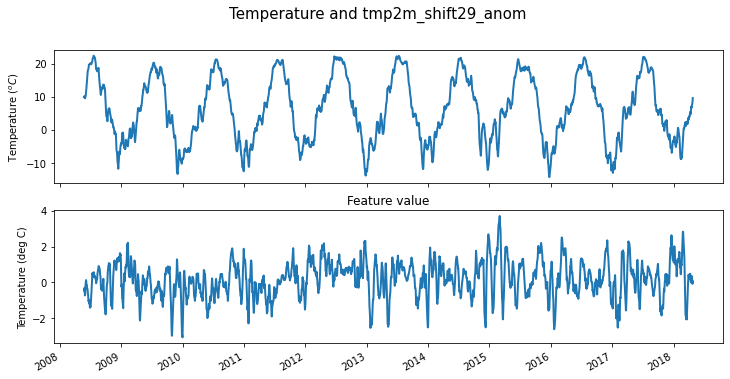

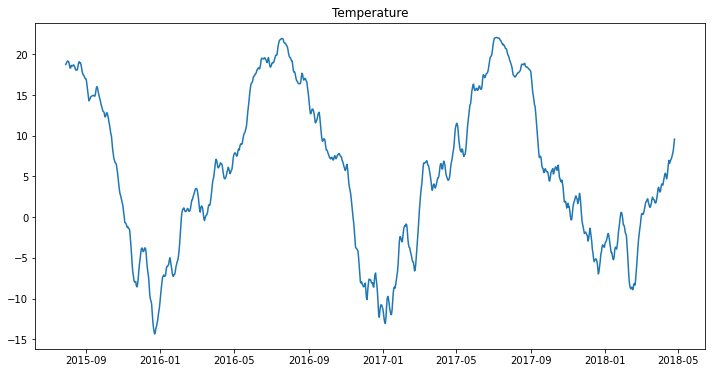

In [5]:
print(Y_train.shape)

colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(dates_train,
        Y_train, lw=2, label="training data")
ax.set_ylabel("Temperature ($^oC$)")

ax = fig.add_subplot(2, 1, 2)

feature_str = "tmp2m_shift29_anom"
ax.plot(dates_train,
        X_train[:, columnstr_to_index[feature_str]], lw=2, label="training data")
ax.set_ylabel("Temperature Anomaly (deg C)" if is_predicting_anomaly else "Temperature (deg C)")
ax.set_title("Feature value")
fig.suptitle(f"Temperature Anomaly and {feature_str}" if is_predicting_anomaly else 
             f"Temperature and {feature_str}",
             fontsize=15)
fig.autofmt_xdate()

plt.figure(figsize=(12, 6))
plt.title(f"Temperature Anomaly" if is_predicting_anomaly else f"Temperature")
plt.plot(dates_train[-1000:], Y_train[-1000:])


In [6]:
print(Y_train.shape)
def build_model(observed_time_series):
#     weekly = tfp.sts.Seasonal(
#         num_seasons=26, 
#         observed_time_series=observed_time_series,
#         num_steps_per_season=14, 
#         name='biweekly'
#     )
    annual = tfp.sts.SmoothSeasonal(
        period=365,
        frequency_multipliers=[1, 2, 4, 12],
        initial_state_prior=tfd.MultivariateNormalDiag(scale_diag=tf.ones([8])),
        observed_time_series=observed_time_series,
        name='annual'
    )
#     seasonal = tfp.sts.Seasonal(
#         num_seasons=4, 
#         observed_time_series=observed_time_series,
#         num_steps_per_season=91, 
#         name='seasonal'
#     )
#     monthly = tfp.sts.Seasonal(
#         num_seasons=12,
#         observed_time_series=observed_time_series,
#         num_steps_per_season=[31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
#         drift_scale_prior=tfd.LogNormal(loc=-1., scale=0.1),
#         initial_effect_prior=tfd.Normal(loc=0., scale=5.),
#         name='month_of_year',
#     )
    features_effects = []
#     features_effects.append(
#         tfp.sts.LinearRegression(
#             design_matrix=X,# - np.mean(X), 
#             name=f"linear_regression"
#         )
#     )
    for feature_name, idx in columnstr_to_index.items():
        features_effects.append(
            tfp.sts.LinearRegression(
                design_matrix=np.expand_dims(X[:, idx], 1),# - np.mean(X), 
                name=f"{feature_name}_{idx}"
            )   
        )
#     autoregressive = tfp.sts.Autoregressive(
#         order=7,
#         observed_time_series=observed_time_series,
#         name='autoregressive'
#     )
#     linear_trend= tfp.sts.LocalLinearTrend()
    sts_components = [
        annual,
#         weekly,
#         seasonal,
#         monthly,
#         autoregressive
#         linear_trend
    ] + features_effects
    model = tfp.sts.Sum(
        sts_components,
        observed_time_series=observed_time_series
    )
    return model

temperature_model = build_model(Y_train)

variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=temperature_model)
print(variational_posteriors)

(3622,)
tfp.distributions.JointDistributionNamed("build_factored_surrogate_posterior_JointDistributionNamed", batch_shape={annual/_drift_scale: [], icec_2010_1_shift30_14/_weights: [], icec_2010_2_shift30_15/_weights: [], icec_2010_3_shift30_16/_weights: [], mei_shift45_9/_weights: [], nmme0_wo_ccsm3_nasa_8/_weights: [], nmme_wo_ccsm3_nasa_7/_weights: [], observation_noise_scale: [], ones_0/_weights: [], phase_shift17_10/_weights: [], pres_shift30_6/_weights: [], rhum_shift30_5/_weights: [], sst_2010_1_shift30_11/_weights: [], sst_2010_2_shift30_12/_weights: [], sst_2010_3_shift30_13/_weights: [], tmp2m_shift29_1/_weights: [], tmp2m_shift29_anom_2/_weights: [], tmp2m_shift58_3/_weights: [], tmp2m_shift58_anom_4/_weights: [], wind_hgt_10_2010_1_shift30_17/_weights: [], wind_hgt_10_2010_2_shift30_18/_weights: []}, event_shape={annual/_drift_scale: [], icec_2010_1_shift30_14/_weights: [1], icec_2010_2_shift30_15/_weights: [1], icec_2010_3_shift30_16/_weights: [1], mei_shift45_9/_weights: 

100
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
Do not call `graph_parents`.
278.10804986953735 seconds


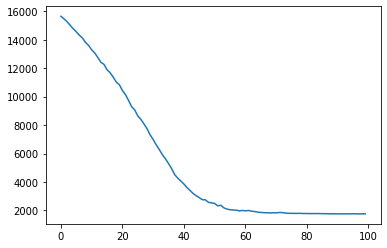

In [7]:
# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 100
print(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=.1)

# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(experimental_compile=True)
def train():
  elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=temperature_model.joint_log_prob(
        observed_time_series=Y_train),
    surrogate_posterior=variational_posteriors,
    optimizer=optimizer,
    num_steps=num_variational_steps)
  return elbo_loss_curve

start = time.time()
elbo_loss_curve = train()
end = time.time()
print(f"{end - start} seconds")
plt.plot(elbo_loss_curve)
plt.show()

In [1]:
print(elbo_loss_curve)

NameError: name 'elbo_loss_curve' is not defined

In [9]:
# Draw samples from the variational posterior.
q_samples_temperature_ = variational_posteriors.sample(50)


print("Inferred parameters:")
for param in temperature_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_temperature_[param.name], axis=0),
                              np.std(q_samples_temperature_[param.name], axis=0)))


Inferred parameters:
observation_noise_scale: 0.044426918029785156 +- 0.0006125813815742731
annual/_drift_scale: 0.17008963227272034 +- 0.0012022783048450947
ones_0/_weights: [-0.5460068] +- [0.14607765]
tmp2m_shift29_1/_weights: [-1.6757228] +- [0.11960223]
tmp2m_shift29_anom_2/_weights: [0.449006] +- [0.04179512]
tmp2m_shift58_3/_weights: [0.30541086] +- [0.1582837]
tmp2m_shift58_anom_4/_weights: [0.11878589] +- [0.04665411]
rhum_shift30_5/_weights: [0.20112905] +- [0.12948105]
pres_shift30_6/_weights: [0.03869343] +- [0.05685436]
nmme_wo_ccsm3_nasa_7/_weights: [0.60183114] +- [0.2500327]
nmme0_wo_ccsm3_nasa_8/_weights: [-0.09720635] +- [0.06091892]
mei_shift45_9/_weights: [0.0475193] +- [0.09701923]
phase_shift17_10/_weights: [0.00828302] +- [0.00816909]
sst_2010_1_shift30_11/_weights: [-2.8982403] +- [0.9105799]
sst_2010_2_shift30_12/_weights: [1.1240777] +- [0.28745613]
sst_2010_3_shift30_13/_weights: [-0.8761706] +- [0.2719501]
icec_2010_1_shift30_14/_weights: [0.29000932] +- [0.

## Forecasting

In [10]:
start = time.time()
temperature_forecast_dist = tfp.sts.forecast(
    model=temperature_model,
    observed_time_series=Y_train[-10 * 365:],
    parameter_samples=q_samples_temperature_,
    num_steps_forecast=num_forecast_steps)
end = time.time()
print(f"time elapsed = {end - start}")

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
time elapsed = 487.7304666042328


skill: 0.9298471212387085


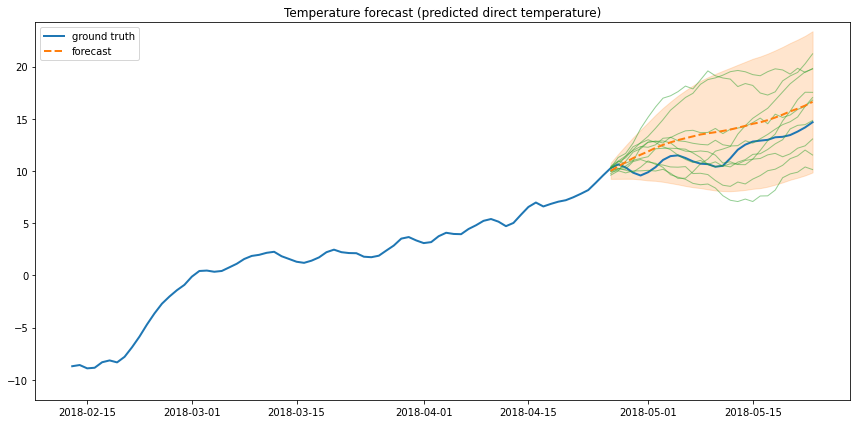

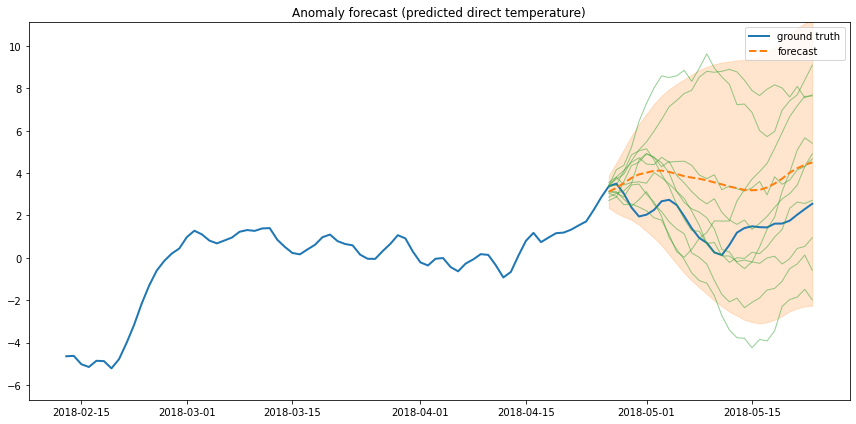

In [11]:
num_samples=10
plot_num = 100

(
    temperature_forecast_mean,
    temperature_forecast_scale,
    temperature_forecast_samples
) = (
    temperature_forecast_dist.mean().numpy()[..., 0],
    temperature_forecast_dist.stddev().numpy()[..., 0],
    temperature_forecast_dist.sample(num_samples).numpy()[..., 0]
    )

if is_predicting_anomaly:
    fig, ax = plot_forecast(dates, anoms + clims,
                            temperature_forecast_mean + clims_test,
                            temperature_forecast_scale,
                            temperature_forecast_samples + clims_test,
                            title="Temperature forecast (predicted anomaly)",
                            plot_num=plot_num,
    )
    fig.tight_layout()
    fig, ax = plot_forecast(dates, anoms,
                            temperature_forecast_mean,
                            temperature_forecast_scale,
                            temperature_forecast_samples,
                            title="Anomaly forecast (predicted anomaly)",
                            plot_num=plot_num,
    )
    fig.tight_layout()

    
    anoms_hat = temperature_forecast_mean[14:]
    anoms_hat_norm = anoms_hat / np.linalg.norm(anoms_hat)
    anoms_test_norm = anoms_test[14:] / np.linalg.norm(anoms_test[14:])
    print(f"skill: {anoms_hat_norm.dot(anoms_test_norm)}")

    
else:
    fig, ax = plot_forecast(dates, temps,
                            temperature_forecast_mean,
                            temperature_forecast_scale,
                            temperature_forecast_samples,
                            title="Temperature forecast (predicted direct temperature)",
                            plot_num=plot_num,
    )
    fig.tight_layout()

    fig, ax = plot_forecast(dates, anoms,
                        temperature_forecast_mean - clims_test,
                        temperature_forecast_scale,
                        temperature_forecast_samples - clims_test,
                        title="Anomaly forecast (predicted direct temperature)",
                        plot_num=plot_num,
    )
    fig.tight_layout()
    
    
    anoms_hat = temperature_forecast_mean[14:] - clims_test[14:]
    anoms_hat_norm = anoms_hat / np.linalg.norm(anoms_hat)
    anoms_test_norm = anoms_test[14:] / np.linalg.norm(anoms_test[14:])
    print(f"skill: {anoms_hat_norm.dot(anoms_test_norm)}")



In [12]:
num_to_plot_for_decomp = 10 * 365
# Get the distributions over component outputs from the posterior marginals on
# training data, and from the forecast model.
component_dists = tfp.sts.decompose_by_component(
    temperature_model,
    observed_time_series=Y_train[-num_to_plot_for_decomp:],
    parameter_samples=q_samples_temperature_
)

forecast_component_dists = tfp.sts.decompose_forecast_by_component(
    temperature_model,
    forecast_dist=temperature_forecast_dist,
    parameter_samples=q_samples_temperature_
)


temperature_component_means_, temperature_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()}
)

temperature_forecast_component_means_, temperature_forecast_component_stddevs_ = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
)


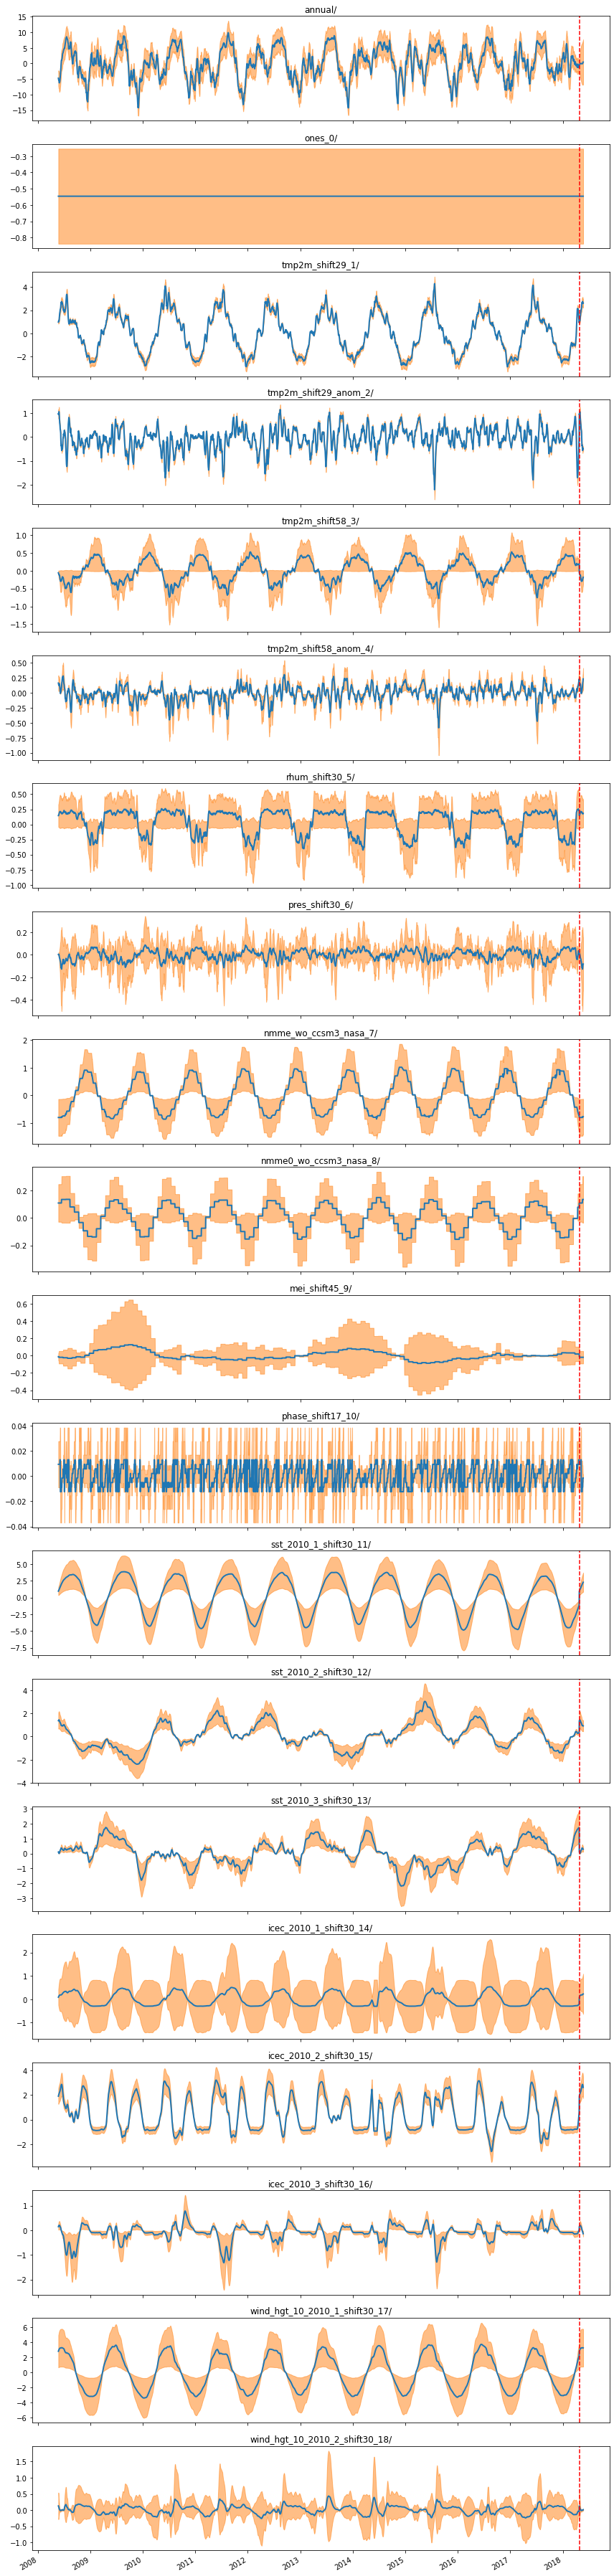

In [13]:
# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
    
for k in temperature_component_means_.keys():
    component_with_forecast_means_[k] = np.concatenate([
        temperature_component_means_[k],
        temperature_forecast_component_means_[k]
    ], axis=-1)
    component_with_forecast_stddevs_[k] = np.concatenate([
        temperature_component_stddevs_[k],
        temperature_forecast_component_stddevs_[k]
    ], axis=-1)

fig, axes = plot_components(
    dates[-num_to_plot_for_decomp:],
    component_with_forecast_means_,
    component_with_forecast_stddevs_,
    vals_to_plot = num_to_plot_for_decomp
)
for ax in axes.values():
  ax.axvline(dates[-num_forecast_steps], linestyle="--", color='red')
